In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, Dense, Flatten, LeakyReLU, add, PReLU, Dropout
from keras.regularizers import l1, l2, l1_l2
from keras.optimizers import Adam
from keras.applications import VGG19
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from google.colab import drive
from scipy.ndimage import gaussian_filter
from keras.applications import VGG19

In [ ]:
drive.mount('/content/drive')

## Preprocessing

In [ ]:
#define constants
HIGH_RES = 224
LOW_RES = 112

N_TRAIN = 1152
N_VAL = 384
N_TEST = 512

batch_size = 16

#paths to LR and HR images
high_res_dir = pathlib.Path('/content/drive/MyDrive/ST456_project_team_afi/high_res_images')
low_res_dir = pathlib.Path('/content/drive/MyDrive/ST456_project_team_afi/low_res_images')

high_res_paths = sorted([str(path) for path in high_res_dir.glob('*.jpg')])
low_res_paths = sorted([str(path) for path in low_res_dir.glob('*.jpg')])

#define splits
train_high_res_paths = high_res_paths[:N_TRAIN]
train_low_res_paths = low_res_paths[:N_TRAIN]
val_high_res_paths = high_res_paths[N_TRAIN:N_TRAIN+N_VAL]
val_low_res_paths = low_res_paths[N_TRAIN:N_TRAIN+N_VAL]
test_high_res_paths = high_res_paths[N_TRAIN+N_VAL:]
test_low_res_paths = low_res_paths[N_TRAIN+N_VAL:]


#resize and normalise to desired range
def preprocess_image(low_res_path, high_res_path):
    low_res_img = tf.io.read_file(low_res_path)
    low_res_img = tf.image.decode_jpeg(low_res_img, channels=3)
    high_res_img = tf.io.read_file(high_res_path)
    high_res_img = tf.image.decode_jpeg(high_res_img, channels=3)

    low_res_img = tf.image.resize(low_res_img, [LOW_RES, LOW_RES])
    high_res_img = tf.image.resize(high_res_img, [HIGH_RES, HIGH_RES])

    low_res_img = (low_res_img / 127.5) - 1
    high_res_img = (high_res_img / 127.5) - 1

    return low_res_img, high_res_img

#define function to create datasets
def create_dataset(low_res_paths, high_res_paths, batch_size, is_training=True):
    ds = tf.data.Dataset.from_tensor_slices((low_res_paths, high_res_paths))
    ds = ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    if is_training:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return ds

#create datasets
train_ds = create_dataset(train_low_res_paths, train_high_res_paths, batch_size, is_training=True)
val_ds = create_dataset(val_low_res_paths, val_high_res_paths, batch_size, is_training=False)
test_ds = create_dataset(test_low_res_paths, test_high_res_paths, batch_size, is_training=False)

## Model Definition

In [ ]:
#define building blocks and models
# the architecture has been designed to follow as close as possible the original architecture from the SRGAN paer
# for a visual representation see figure 3 in the paper
class residualBlock(tf.keras.layers.Layer):
  def __init__(self, dropout_rate=0.0):
    super(residualBlock, self).__init__()
    self.add = tf.keras.layers.Add()
    self.seq = tf.keras.models.Sequential(
        [
            tf.keras.layers.Conv2D(64, (3,3), padding = "same"),
            tf.keras.layers.BatchNormalization(momentum = 0.5),
            tf.keras.layers.PReLU(shared_axes = [1,2]),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Conv2D(64, (3,3), padding = "same"),
            tf.keras.layers.BatchNormalization(momentum = 0.5),
        ]
    )

  def call(self, x):
    return self.add([x, self.seq(x)])

class upscaleBlock(tf.keras.layers.Layer):
  def __init__(self):
    super(upscaleBlock, self).__init__()
    self.seq = tf.keras.models.Sequential(
        [
            tf.keras.layers.Conv2D(256, (3,3), padding="same"),
            tf.keras.layers.UpSampling2D(size = 2),
            tf.keras.layers.PReLU(shared_axes=[1,2]),
        ]
    )

  def call(self, x):
    return self.seq(x)


class discriminatorBlock(tf.keras.layers.Layer):
  def __init__(self, filters, strides=1, bn=True, l1_factor=0.00, l2_factor=0.00):
    super(discriminatorBlock, self).__init__()
    if bn is True:
      self.seq = tf.keras.models.Sequential(
          [
              tf.keras.layers.Conv2D(filters, (3,3), strides = strides, padding="same", kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor)),
              tf.keras.layers.BatchNormalization(momentum=0.8),
              tf.keras.layers.LeakyReLU(alpha=0.2),
          ]
      )
    else:
      self.seq = tf.keras.models.Sequential(
          [
              tf.keras.layers.Conv2D(filters, (3,3), strides = strides, padding="same", kernel_regularizer=l1_l2(l1=l1_factor, l2=l2_factor)),
              tf.keras.layers.LeakyReLU(alpha=0.2),
          ]
      )

  def call(self, x):
    return self.seq(x)



In [ ]:
def create_gen(input, num_res_block):
    x = Conv2D(64, (9,9), padding="same")(input)
    x = PReLU(shared_axes=[1,2])(x)

    residual = x

    for i in range(num_res_block):
        x = residualBlock()(x)

    x = Conv2D(64, (3,3), padding="same")(x)
    x = BatchNormalization(momentum=0.5)(x)
    x = add([x,residual])

    x = upscaleBlock()(x)

    output = Conv2D(3, (9,9), padding="same")(x)

    return Model(inputs=input, outputs=output)

def create_disc(input_shape):
    input = Input(shape=input_shape)
    x = discriminatorBlock(64, bn=False)(input)
    x = discriminatorBlock(64, strides=2)(x)
    x = discriminatorBlock(128)(x)
    x = discriminatorBlock(128, strides=2)(x)
    x = discriminatorBlock(256)(x)
    x = discriminatorBlock(256, strides=2)(x)
    x = discriminatorBlock(512)(x)
    x = discriminatorBlock(512, strides=2)(x)

    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input, outputs=output)
    model.summary()
    return model


# download vgg and initialize with pre-trained weights
def build_vgg(hr_shape):

    vgg = VGG19(weights="imagenet", include_top=False, input_shape=(HIGH_RES,HIGH_RES,3))

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)


def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)

    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])


In [ ]:
#define shape of input
hr_shape = (HIGH_RES, HIGH_RES, 3)
lr_shape = (LOW_RES, LOW_RES, 3)

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)


#compile generator
generator = create_gen(lr_ip, num_res_block=16)
generator.summary()


#compile discriminator
discriminator = create_disc(hr_shape)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()


#load VGG19
vgg = build_vgg((224, 224, 3))
vgg.trainable = False
print(vgg.summary())


#compile SRGAN
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 112, 112, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         15616     ['input_1[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 112, 112, 64)         64        ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 112, 112, 64)         36928     ['p_re_lu[0][0]']             
                                                                                              

## Training

In [ ]:
EPOCHS = 50

#custom training loop
for e in range(EPOCHS):
    g_losses = []
    d_losses = []

    for lr_imgs, hr_imgs in train_ds:
        #check shaopes for degugging
        print("LR Images Shape:", lr_imgs.shape)
        print("HR Images Shape:", hr_imgs.shape)

        #generate SR-images
        fake_imgs = generator.predict_on_batch(lr_imgs)

        #train discriminator
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(hr_imgs, np.ones((lr_imgs.shape[0], 1)))
        d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((lr_imgs.shape[0], 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        #train generator
        discriminator.trainable = False
        image_features = vgg.predict(hr_imgs)
        g_loss = gan_model.train_on_batch([lr_imgs, hr_imgs], [np.ones((lr_imgs.shape[0], 1)), image_features])

        #keep track of losses
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    g_loss_avg = np.mean(g_losses)
    d_loss_avg = np.mean(d_losses)
    print(f"Epoch: {e+1}, Generator Loss: {g_loss_avg}, Discriminator Loss: {d_loss_avg}")

    #save model regularly since we frequently faced the issue of insufficient RAM
    if (e + 1) % 10 == 0:
        generator_filename = f'/content/drive/MyDrive/generator_epoch_{e+1}.h5'
        generator.save(generator_filename)
        print(f"Saved generator model to {generator_filename}")

        discriminator_filename = f'/content/drive/MyDrive/discriminator_epoch_{e+1}.h5'
        discriminator.save(discriminator_filename)
        print(f"Saved discriminator model to {discriminator_filename}")

LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 26ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 24ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 26ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 25ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 26ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 25ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 24ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 24ms/step
LR Images Shape: (16, 11

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch: 10, Generator Loss: 7.833906163220052, Discriminator Loss: 0.7778381959611175
Saved generator model to /content/drive/MyDrive/generator_epoch_10.h5
Saved discriminator model to /content/drive/MyDrive/discriminator_epoch_10.h5
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 26ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 27ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 26ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 25ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 34ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 25ms/step
LR Images Shape: (16, 112, 112, 3)


Epoch: 20, Generator Loss: 5.381922910697068, Discriminator Loss: 0.6673528078880692
Saved generator model to /content/drive/MyDrive/generator_epoch_20.h5
Saved discriminator model to /content/drive/MyDrive/discriminator_epoch_20.h5
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 26ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 24ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 24ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 25ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 25ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 24ms/step
LR Images Shape: (16, 112, 112, 3)


Epoch: 30, Generator Loss: 7.478330553785242, Discriminator Loss: 0.5024424353957998
Saved generator model to /content/drive/MyDrive/generator_epoch_30.h5
Saved discriminator model to /content/drive/MyDrive/discriminator_epoch_30.h5
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 30ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 28ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 28ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 27ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 28ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 27ms/step
LR Images Shape: (16, 112, 112, 3)


Epoch: 40, Generator Loss: 7.756834573868273, Discriminator Loss: 0.5
Saved generator model to /content/drive/MyDrive/generator_epoch_40.h5
Saved discriminator model to /content/drive/MyDrive/discriminator_epoch_40.h5
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 26ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 24ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 24ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 25ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 28ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape: (16, 224, 224, 3)
1/1 [==============================] - 0s 26ms/step
LR Images Shape: (16, 112, 112, 3)
HR Images Shape

Epoch: 50, Generator Loss: 6.018129919691105, Discriminator Loss: 0.5
Saved generator model to /content/drive/MyDrive/generator_epoch_50.h5
Saved discriminator model to /content/drive/MyDrive/discriminator_epoch_50.h5


In [ ]:
#sanity check: visualise first n images of test set

image_data = []

N_VISUALISATION = 3

for low_res_batch, high_res_batch in test_ds.take(1):
    low_res_batch = low_res_batch[:N_VISUALISATION]
    high_res_batch = high_res_batch[:N_VISUALISATION]
    print(high_res_batch.shape)
    print(low_res_batch.shape)

    sr_batch = generator.predict(low_res_batch)
    min_val = np.min(sr_batch)
    max_val = np.max(sr_batch)

    #for debugging track min and max value of prediction
    print("Minimum value in super-resolution batch:", min_val)
    print("Maximum value in super-resolution batch:", max_val)

    #clip to ensure correct range
    sr_batch = tf.clip_by_value(sr_batch, -1, 1)

    #convert for visualisation
    low_res_batch = low_res_batch.numpy()
    high_res_batch = high_res_batch.numpy()
    sr_batch = sr_batch.numpy()

    for lr_img, sr_img, hr_img in zip(low_res_batch, sr_batch, high_res_batch):
        image_data.append((lr_img, sr_img, hr_img))



(3, 224, 224, 3)
(3, 112, 112, 3)
1/1 [==============================] - 1s 1s/step
Minimum value in super-resolution batch: -1.1099832
Maximum value in super-resolution batch: 1.1617458


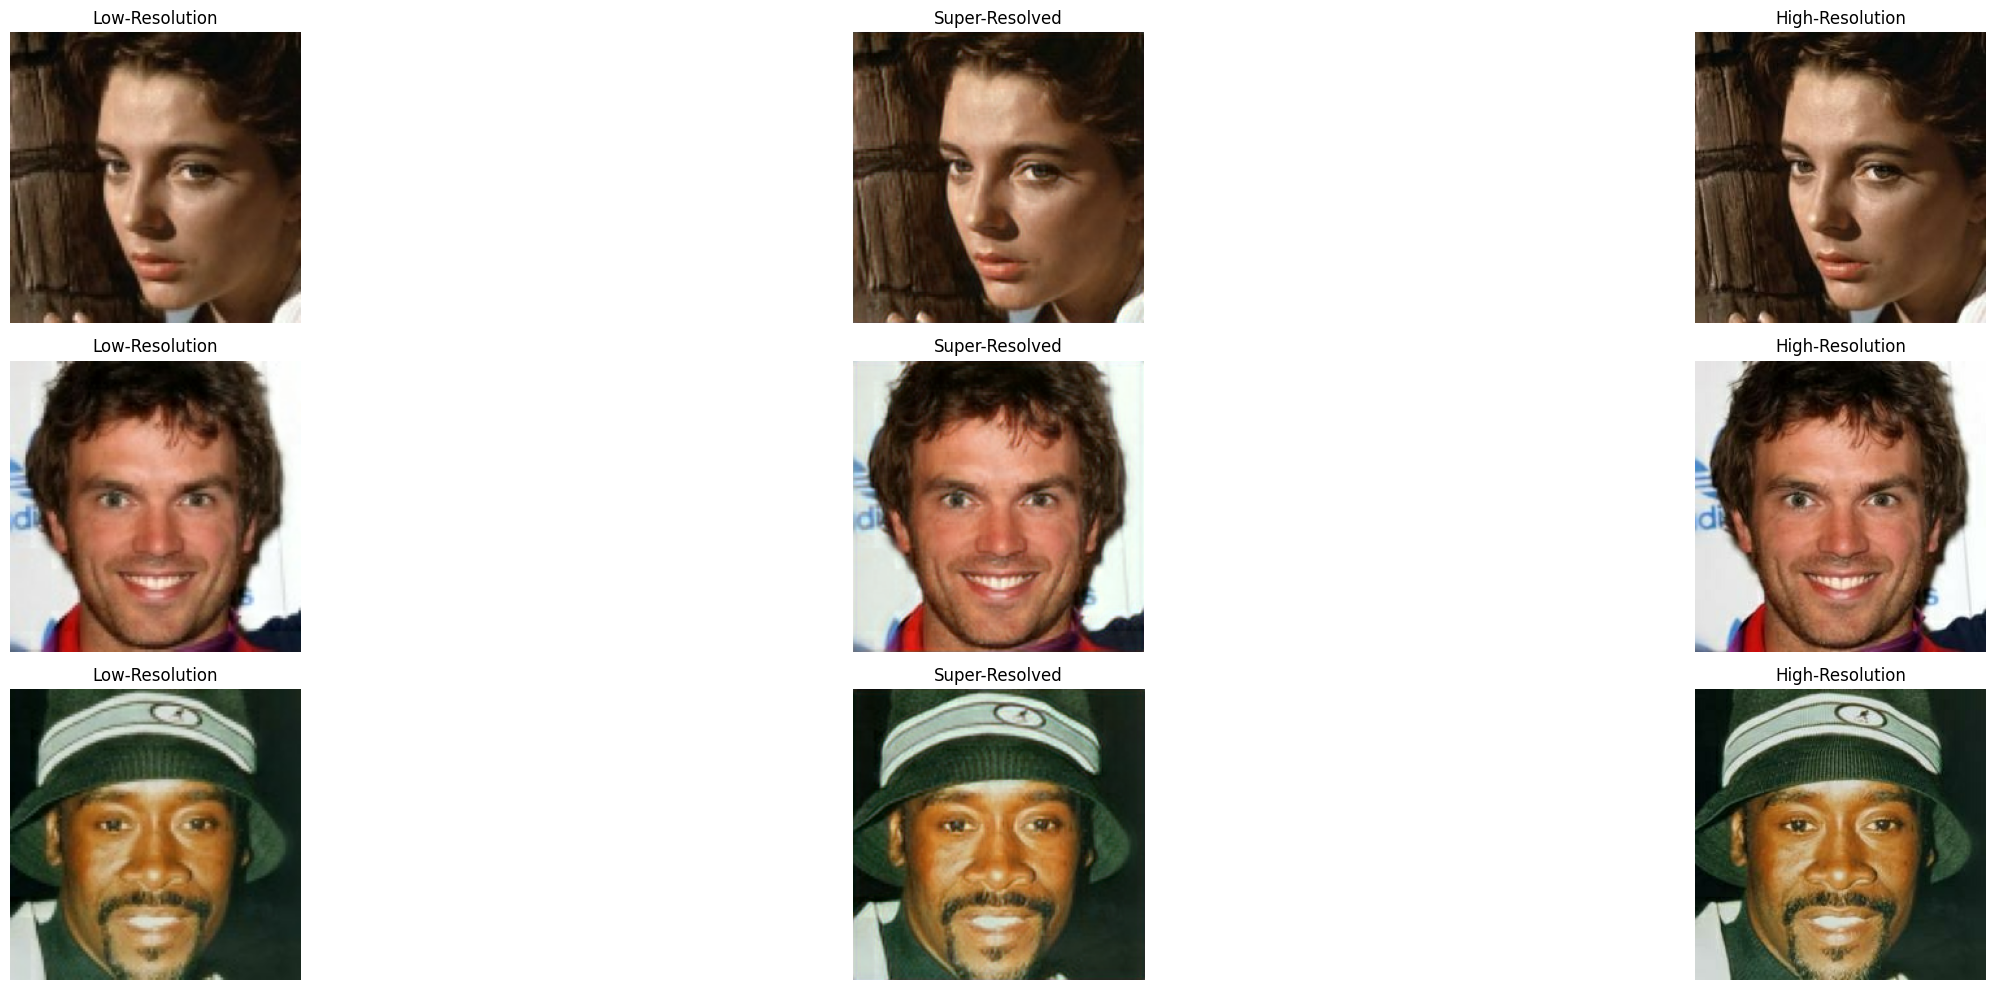

In [ ]:
#define plotting function
def plot_images(image_data, n_images, figsize=(30, 10)):
    plt.figure(figsize=figsize)
    titles = ['Low-Resolution', 'Super-Resolved', 'High-Resolution']
    for i in range(n_images):
        lr_img, sr_img, hr_img = image_data[i]
        lr_img = np.clip((lr_img + 1) * 127.5, 0, 255).astype('uint8')
        sr_img = np.clip((sr_img + 1) * 127.5, 0, 255).astype('uint8')
        hr_img = np.clip((hr_img + 1) * 127.5, 0, 255).astype('uint8')

        images = [lr_img, sr_img, hr_img]

        for j, img in enumerate(images):
            plt.subplot(n_images, 3, i * 3 + j + 1)
            plt.imshow(img)
            plt.title(titles[j])
            plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_images(image_data, n_images=N_VISUALISATION)

## Inference

In [ ]:
#define function for inference to align code with SR3
def perform_inference(generator, low_res_batch):
    sr_batch = generator.predict(low_res_batch)
    sr_batch = (sr_batch + 1) * 0.5 #rescale
    return sr_batch

#compute PSNR and SSIM
def evaluate_metrics(hr_img, sr_img):
    hr_img = (hr_img + 1) * 0.5
    psnr = tf.image.psnr(hr_img, sr_img, max_val=1.0)
    ssim = tf.image.ssim(hr_img, sr_img, max_val=1.0)
    return psnr.numpy(), ssim.numpy()

In [ ]:
#calculate performance metrics on test set

psnr_values = []
ssim_values = []

for low_res_batch, high_res_batch in test_ds:
    sr_batch = perform_inference(generator, low_res_batch)
    for hr_img, sr_img in zip(high_res_batch, sr_batch):
        psnr, ssim = evaluate_metrics(hr_img, sr_img)
        psnr_values.append(psnr)
        ssim_values.append(ssim)

average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)

print(f"Average PSNR: {average_psnr:.2f} dB")
print(f"Average SSIM: {average_ssim:.4f}")

1/1 [==============================] - 0s 28ms/step
Average PSNR: 30.25 dB
Average SSIM: 0.8976


## XAI: Saliency Map

In [ ]:
#load model
lr_ip = Input(shape=(LOW_RES, LOW_RES, 3))
generator = create_gen(lr_ip, num_res_block=16)
generator.load_weights('/content/drive/MyDrive/ST456_project_team_afi/0_SRGAN_final/generator_epoch_50.h5')

In [ ]:
#define function to calculare saliency
def calc_saliency(vgg, model, low_res_image, high_res_image):
    with tf.GradientTape() as tape:
        tape.watch(low_res_image)
        sr_image = model(low_res_image, training=False)
        sr_features = vgg(sr_image)
        hr_features = vgg(high_res_image)
        loss = tf.reduce_mean(tf.square(hr_features - sr_features))

    gradient = tape.gradient(loss, low_res_image)
    gradient = tf.reduce_max(tf.abs(gradient), axis=-1).numpy()

    #blur gradient for better visualisation
    gradient_blurred = gaussian_filter(gradient, sigma=1)

    min_val, max_val = np.min(gradient_blurred), np.max(gradient_blurred)
    saliency_map_normalized = (gradient_blurred - min_val) / (max_val - min_val + np.finfo(float).eps)

    return saliency_map_normalized

1/1 [==============================] - 10s 10s/step


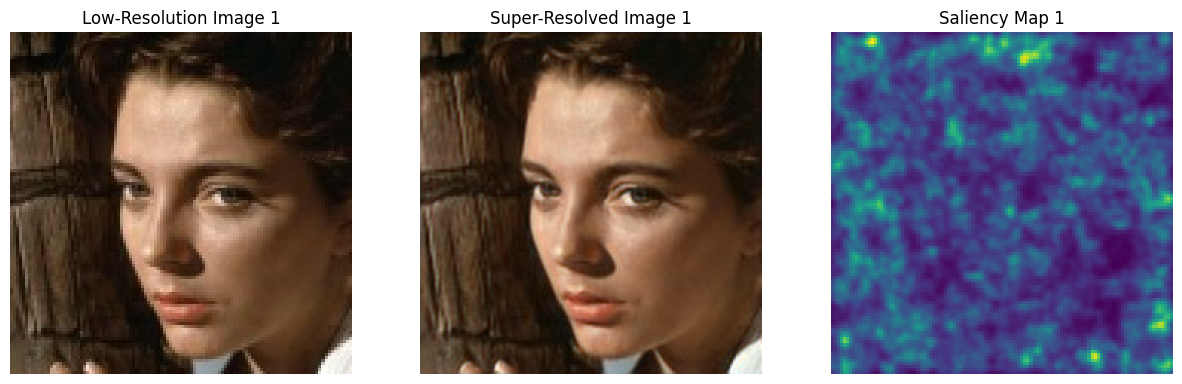

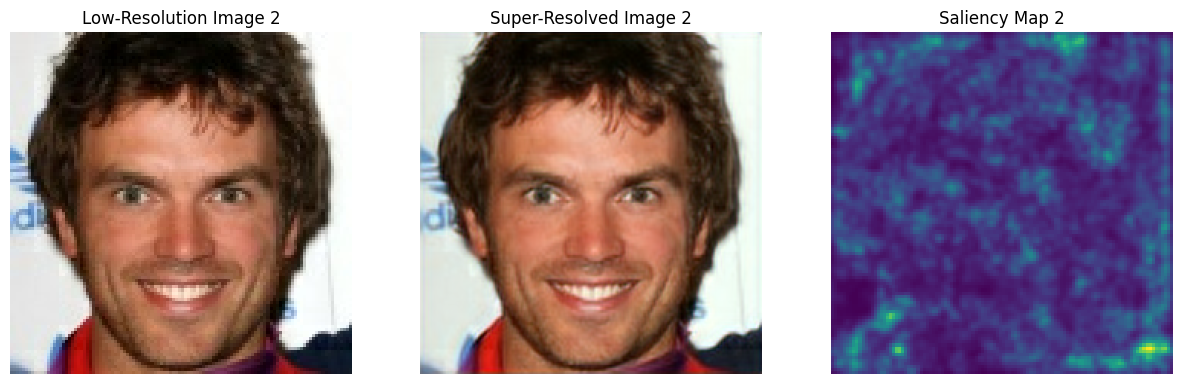

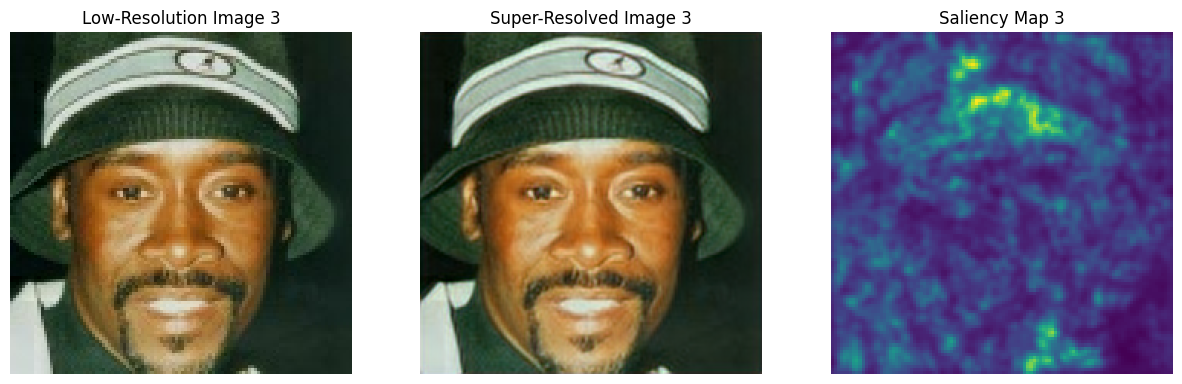

In [ ]:
#calculate for first 3 images of test set
low_res_batch, high_res_batch = next(iter(test_ds))
sr_batch = generator.predict(low_res_batch)

for i in range(3):
    low_res_image = tf.expand_dims(low_res_batch[i], axis=0)
    high_res_image = tf.expand_dims(high_res_batch[i], axis=0)

    #compute saliency map
    saliency_map = calc_saliency(vgg, generator, low_res_image, high_res_image)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    low_res_img = (low_res_batch[i].numpy() + 1) * 0.5
    low_res_img_clipped = np.clip(low_res_img, 0, 1)
    plt.imshow(low_res_img_clipped)
    plt.title(f'Low-Resolution Image {i+1}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    sr_img = (sr_batch[i] + 1) * 0.5
    sr_img_clipped = np.clip(sr_img, 0, 1)
    plt.imshow(sr_img_clipped)
    plt.title(f'Super-Resolved Image {i+1}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    saliency_map_clipped = np.clip(saliency_map.squeeze(), 0, 1)
    plt.imshow(saliency_map_clipped)
    plt.title(f'Saliency Map {i+1}')
    plt.axis('off')

    plt.show()

In [ ]:
("/content/drive/MyDrive/ST456_project_team_afi/0_SR3_final/SR3.keras")